# Goal

To implemet the first structure (best one) proposed in the related paper.

Successive refinement - struct 1 - 5 stage
- Single encoder - seperate decoders
 - Single encoder
 - Multiple decoder
 - each decoder receives its own data and previous decoders data
 - **complex** symbols are used

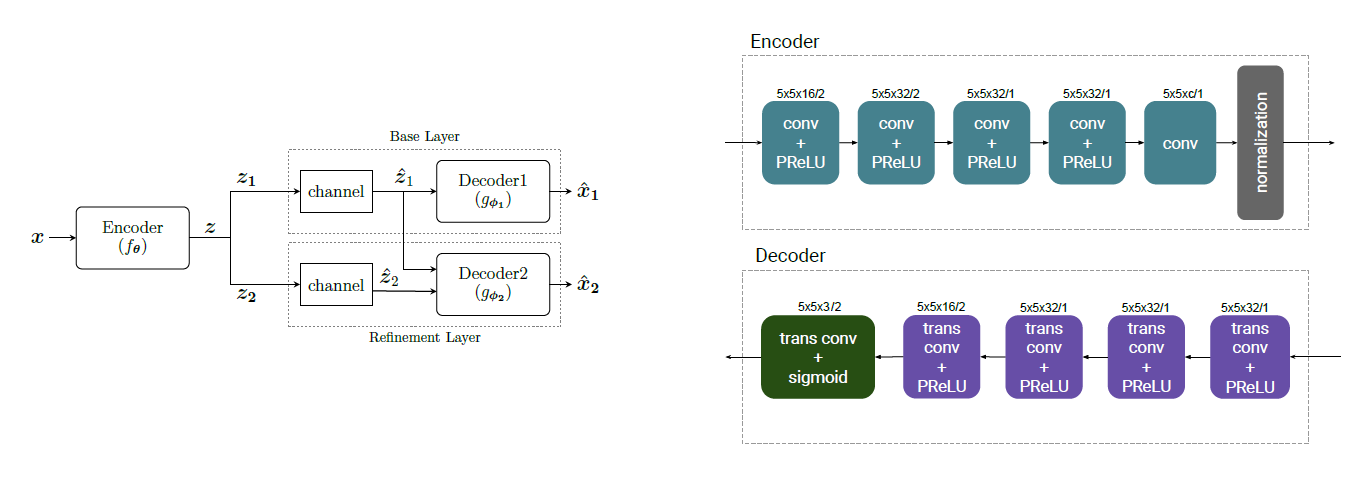

# Importing stuff

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

import matplotlib.pyplot as plt
import time
import os

In [ ]:
%load_ext tensorboard
!rm -rf ./logs/   # Clear any logs from previous runs

# (Hyper) params

In [ ]:
ps = 64   # patch size (Height and Width)
enc_chs = 5 * 4*2    # compression_ratio = 5 * 1/12
stages_count = 5
dec_chs = enc_chs // stages_count
SNR = 13

epochs = 500
batch_size = int(32 * (32/ps)**2)
loss_func = keras.losses.MeanSquaredError()

drive_dir = '/content/drive/'
JSCC_dir = os.path.join(drive_dir, 'MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2')
JSCC_channel_name = 'Channel'   # to save the channel with this name, for further usage

train_count = int(50000 * (32/ps)**2)   # number of patches in trainset
test_count = int(10000 * (32/ps)**2)   # number of patches in testset

# New stuff

## PowerNormalize layer

In [ ]:
class PowerNormParts(Layer):
  def __init__(self, parts_count, cplx = False, part_last_dim = True, **kwargs):
    super(PowerNormParts, self).__init__(**kwargs)
    self.pc = parts_count
    self.cplx = cplx
    self.part_last_dim = part_last_dim    # if False, partitions the second dim

  def call(self, inputs):
    shape = tf.shape(inputs)
    if self.part_last_dim:
      inputs = tf.reshape(inputs, (shape[0], -1, shape[-1]))
      inputs = tf.transpose(inputs, perm = [0, 2, 1])

    flatp = tf.reshape(inputs, (shape[0], self.pc, -1))
    if self.cplx == True:
      dsize = tf.shape(flatp)[2] // 2
    else:
      dsize = tf.shape(flatp)[2]
    dsize_f = tf.cast(dsize, dtype = tf.float32)

    norm = tf.math.real(tf.norm(flatp, axis = 2))
    norm = tf.expand_dims(norm, -1)

    out = tf.sqrt(dsize_f) * flatp / norm
    if self.part_last_dim:
      out = tf.reshape(out, (shape[0], shape[-1], -1))
      out = tf.transpose(out, perm = [0, 2, 1])
    out = tf.reshape(out, shape)
    return out

## Channel layer

In [ ]:
class Channel(Layer):
  def __init__(self, snr, cplx = False, **kwargs):
    super(Channel, self).__init__(**kwargs)
    self.cplx = cplx
    self.set_snr(snr)

  def call(self, inputs):
    shape = tf.shape(inputs)
    gnoise = tf.random.normal(shape, mean = 0, stddev = self.noise_std)
    return inputs + gnoise

  def get_snr(self):
    return self.snr

  def set_snr(self, snr):
    self.snr = snr
    if self.cplx == True:
      self.noise_std = np.sqrt(10**(-snr/10)) / np.sqrt(2)
    else:
      self.noise_std = np.sqrt(10**(-snr/10))

## PSNR plotter

In [ ]:
def PSNR_plotter(x_axis, model, channel, testX, stages_count = 1, goal = None):
  sc = stages_count
  PSNRs = np.zeros((sc, len(x_axis)))
  pre_snr = channel.get_snr()
  for i, snr in enumerate(x_axis):
    channel.set_snr(snr)
    preds = model(testX)
    for j in range(sc):
      PSNRs[j, i] = tf.reduce_mean(tf.image.psnr(testX, preds[j], max_val = 1.0))
  channel.set_snr(pre_snr)

  if sc == 1:
    plt.plot(x_axis, PSNRs[i], label = 'Model')
  else:
    for i in range(sc):
      plt.plot(x_axis, PSNRs[i], label = 'Stage_' + str(i+1))
  if goal is not None:
    plt.plot(x_axis, goal, label = 'Goal')
  plt.legend(loc = 'lower right')
  plt.grid()
  plt.show()

## PSNR metric

In [ ]:
class PSNR_metric(keras.metrics.Metric):
  def __init__(self, name = "PSNR", **kwargs):
    super(PSNR_metric, self).__init__(name = name, **kwargs)
    self.PSNR_additive = self.add_weight(name='PSNR_additive', initializer = 'zeros')
    self.counter = self.add_weight(name='counter', initializer = 'zeros')

  def update_state(self, y_true, y_pred, sample_weight = None):
    self.PSNR_additive.assign_add(tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val = 1.0)))
    self.counter.assign_add(1)

  def result(self):
    return self.PSNR_additive / self.counter

  def reset_states(self):
    self.PSNR_additive.assign(0)
    self.counter.assign(0)

## Learning rate scheduler

In [ ]:
def lr_scheduler(epoch, lr):
  if epoch == 0:
    print("\nlearning_rate: 0.001")
  elif epoch == 20:
    print("\nlearning_rate: 0.0005")
  elif epoch == 30:
    print("\nlearning_rate: 0.0001")

  if epoch < 20:
    return 0.001
  elif epoch < 30:
    return 0.0005
  else:
    return 0.0001

## Function caller

In [ ]:
class FuncCaller(keras.callbacks.Callback):
  def __init__(self, period, function, *args, **kwargs):
    super(FuncCaller, self).__init__()
    self.period = period
    self.fn = function
    self.args = args
    self.kwargs = kwargs

  def on_epoch_end(self, epoch, logs = None):
    if epoch % self.period == 0:
      # if fn wants `epoch` or `logs`, it should accept them as parameters
      self.fn(*self.args, **self.kwargs)

## Epoch dotter

In [ ]:
class EpochDotter(keras.callbacks.Callback):
  def __init__(self, nl_period, dot_period = 1):
    super(EpochDotter, self).__init__()
    self.nl_period = nl_period
    self.dot_period = dot_period
    self.tic = None

  def on_epoch_end(self, epoch, logs = None):
    if epoch % self.dot_period == 0:
      print('.', end = '')

    if epoch % self.nl_period == 0:
      toc = time.time()
      print(" {} epochs".format(epoch), end = '')
      if self.tic is not None:
        print(" - {0:.2f}s/epoch".format((toc - self.tic)/self.nl_period), end = '')
      for key in list(logs.keys()):
        if "val" in key:
          print(" - {}: {}".format(key, logs[key]), end = '')
      print("")
      self.tic = time.time()

# Initialization

In [ ]:
if len(tf.config.list_physical_devices('GPU')) > 0:
  !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 460.32.03, 15109 MiB


In [ ]:
from google.colab import drive
drive.mount(drive_dir)

Mounted at /content/drive/


In [ ]:
images, info = tfds.load('imagenet_a', split='test', batch_size = None, as_supervised = True, with_info = True)

In [ ]:
imgs_np_itr = images.as_numpy_iterator()

trainX = []
enough = False
l = 0
while not enough:
  img, label = imgs_np_itr.next()

  shape = img.shape
  tile_dim0 = shape[0] // ps
  tile_dim1 = shape[1] // ps
  patches = img[:tile_dim0 * ps, :tile_dim1 * ps]
  patches = patches.reshape(tile_dim0, ps, tile_dim1, ps, shape[-1])
  patches = patches.transpose(0, 2, 1, 3, 4)
  patches = patches.reshape(tile_dim0 * tile_dim1, ps, ps, shape[-1])

  trainX.append(patches)
  l += len(patches)
  if l > (train_count + test_count):
    enough = True

trainX = np.vstack(trainX)
trainX = trainX[:train_count + test_count]
trainX, testX = trainX[:train_count], trainX[train_count:]

trainX = trainX.astype('float32') / 255.
testX = testX.astype('float32') / 255.

In [ ]:
del images
del imgs_np_itr

# Build the model

## Encoder

In [ ]:
def create_encoder(out_chs, img_shape = (None, None, 3), name = None):
  encoder = Sequential(name = name)
  encoder.add(Input(img_shape))
  encoder.add(Conv2D(16, (5, 5), (2, 2), padding = 'same'))
  encoder.add(PReLU(shared_axes = [1, 2]))
  encoder.add(Conv2D(32, (5, 5), (2, 2), padding = 'same'))
  encoder.add(PReLU(shared_axes = [1, 2]))
  encoder.add(Conv2D(32, (5, 5), (1, 1), padding = 'same'))
  encoder.add(PReLU(shared_axes = [1, 2]))
  encoder.add(Conv2D(32, (5, 5), (1, 1), padding = 'same'))
  encoder.add(PReLU(shared_axes = [1, 2]))
  encoder.add(Conv2D(out_chs, (5, 5), (1, 1), padding = 'same'))
  return encoder

## Decoder

In [ ]:
def create_decoder(input_shape, img_chs = 3, name = None):
  decoder = Sequential(name = name)
  decoder.add(Input(input_shape))
  decoder.add(Conv2DTranspose(32, (5, 5), (1, 1), padding = 'same'))
  decoder.add(PReLU(shared_axes = [1, 2]))
  decoder.add(Conv2DTranspose(32, (5, 5), (1, 1), padding = 'same'))
  decoder.add(PReLU(shared_axes = [1, 2]))
  decoder.add(Conv2DTranspose(32, (5, 5), (1, 1), padding = 'same'))
  decoder.add(PReLU(shared_axes = [1, 2]))
  decoder.add(Conv2DTranspose(16, (5, 5), (2, 2), padding = 'same'))
  decoder.add(PReLU(shared_axes = [1, 2]))
  decoder.add(Conv2DTranspose(img_chs , (5, 5), (2, 2), padding = 'same', activation = 'sigmoid'))
  return decoder

## Model

In [ ]:
# layers creation
encoder = create_encoder(enc_chs, img_shape = (None, None, 3), name = "Encoder")
powernorm = PowerNormParts(stages_count, cplx = True, name = "PowerNorm")
channel = Channel(SNR, cplx = True, name = JSCC_channel_name)
decoders = []
for i in range(stages_count):
  decoders.append(create_decoder((None, None, dec_chs*(i+1)), img_chs = 3, name = "Decoder_" + str(i+1)))

# constructing the model
model_input = Input((None, None, 3))
encoder_out = encoder(model_input)
power_out = powernorm(encoder_out)
channel_out = channel(power_out)
outputs = []
losses = []
for i in range(stages_count):
  outputs.append(decoders[i](channel_out[:, :, :, :dec_chs*(i+1)]))
  losses.append(loss_func(model_input, outputs[i]))

raw_model = keras.Model(model_input, outputs)
model = keras.Model(model_input, outputs)

for loss in losses:
  model.add_loss(loss)

In [ ]:
raw_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Encoder (Sequential)            (None, None, None, 4 97464       input_7[0][0]                    
__________________________________________________________________________________________________
PowerNorm (PowerNormParts)      (None, None, None, 4 0           Encoder[0][0]                    
__________________________________________________________________________________________________
Channel (Channel)               (None, None, None, 4 0           PowerNorm[0][0]                  
______________________________________________________________________________________________

# Compile and fit

In [ ]:
opt = keras.optimizers.Adam()
model.compile(optimizer = opt, metrics = [PSNR_metric()])

In [ ]:
known_SNRs  = [1, 4, 7, 13, 19]
test_SNRs   = [1, 4, 7, 10, 13, 16, 19, 22, 25]
known_goals = [[24.636, 25.964, 26.618, 26.945, 27.109, 27.182, 27.236, 27.255, 27.273],
              [23.836, 26.655, 28.091, 28.909, 29.309, 29.527, 29.636, 29.673, 29.709],
              [21.836, 25.945, 28.545, 30.091, 31.055, 31.618, 31.945, 32.091, 32.182],
              [21.036, 23.836, 26.455, 28.854, 30.836, 32.345, 33.382, 34.036, 34.382],
              [20.291, 23.127, 25.891, 28.473, 30.745, 32.655, 34.073, 35.036, 35.600]]

idx = np.where(np.array(known_SNRs) == SNR)[0]
if idx.size == 0:
  goal = None
else:
  idx = idx[0]
  goal = known_goals[idx]

goal = None   # we don't want to use the result of main paper here

In [ ]:
lr_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)

cp_weights_filepath = os.path.join(JSCC_dir, 'weights/weights')
cp_weights_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath = cp_weights_filepath, save_weights_only = True,
    save_best_only = True, period = 1, verbose = 0)

cp_model_filepath = os.path.join(JSCC_dir, 'model')
cp_model_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath = cp_model_filepath, save_weights_only = False,
    save_best_only = False, period = 50, verbose = 0)

plt_cb = FuncCaller(20, PSNR_plotter, x_axis = test_SNRs, model = model,
                    channel = channel, testX = testX,
                    stages_count = stages_count, goal = goal)

ed_cb = EpochDotter(10)


learning_rate: 0.001
. 0 epochs - val_loss: 0.04538814723491669 - val_Decoder_1_PSNR: 21.953393936157227 - val_Decoder_2_PSNR: 22.095365524291992 - val_Decoder_3_PSNR: 21.954591751098633 - val_Decoder_4_PSNR: 22.180944442749023 - val_Decoder_5_PSNR: 22.031709671020508


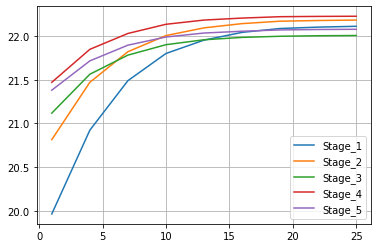

.......... 10 epochs - 27.55s/epoch - val_loss: 0.012460803613066673 - val_Decoder_1_PSNR: 28.040042877197266 - val_Decoder_2_PSNR: 28.276430130004883 - val_Decoder_3_PSNR: 28.47759246826172 - val_Decoder_4_PSNR: 28.695615768432617 - val_Decoder_5_PSNR: 28.585102081298828
.........
learning_rate: 0.0005
. 20 epochs - 26.32s/epoch - val_loss: 0.010021040216088295 - val_Decoder_1_PSNR: 28.857486724853516 - val_Decoder_2_PSNR: 29.218416213989258 - val_Decoder_3_PSNR: 29.721214294433594 - val_Decoder_4_PSNR: 29.862163543701172 - val_Decoder_5_PSNR: 29.95402717590332


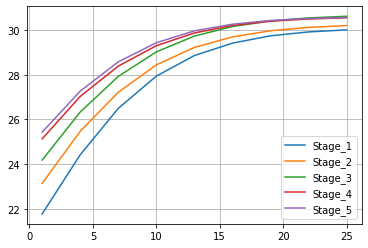

.........
learning_rate: 0.0001
. 30 epochs - 26.93s/epoch - val_loss: 0.007621938828378916 - val_Decoder_1_PSNR: 30.32741355895996 - val_Decoder_2_PSNR: 30.86347770690918 - val_Decoder_3_PSNR: 31.221576690673828 - val_Decoder_4_PSNR: 31.4796199798584 - val_Decoder_5_PSNR: 31.579975128173828
.......... 40 epochs - 26.13s/epoch - val_loss: 0.007264787796884775 - val_Decoder_1_PSNR: 30.64975357055664 - val_Decoder_2_PSNR: 31.152057647705078 - val_Decoder_3_PSNR: 31.52458953857422 - val_Decoder_4_PSNR: 31.78253936767578 - val_Decoder_5_PSNR: 31.929927825927734


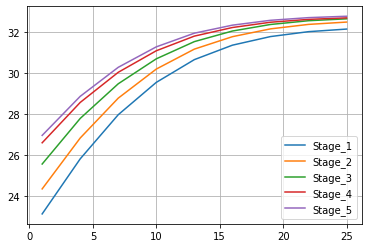

.........INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


. 50 epochs - 28.19s/epoch - val_loss: 0.007081367541104555 - val_Decoder_1_PSNR: 30.678312301635742 - val_Decoder_2_PSNR: 31.184682846069336 - val_Decoder_3_PSNR: 31.53064727783203 - val_Decoder_4_PSNR: 31.7497501373291 - val_Decoder_5_PSNR: 31.85596466064453
.......... 60 epochs - 26.23s/epoch - val_loss: 0.006579279433935881 - val_Decoder_1_PSNR: 30.880550384521484 - val_Decoder_2_PSNR: 31.48602867126465 - val_Decoder_3_PSNR: 31.868614196777344 - val_Decoder_4_PSNR: 32.157737731933594 - val_Decoder_5_PSNR: 32.231956481933594


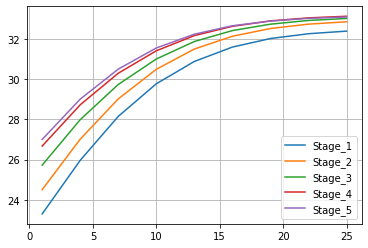

.......... 70 epochs - 26.78s/epoch - val_loss: 0.006211790256202221 - val_Decoder_1_PSNR: 31.023151397705078 - val_Decoder_2_PSNR: 31.623676300048828 - val_Decoder_3_PSNR: 31.930830001831055 - val_Decoder_4_PSNR: 32.20088195800781 - val_Decoder_5_PSNR: 32.268341064453125
.......... 80 epochs - 26.20s/epoch - val_loss: 0.005922225769609213 - val_Decoder_1_PSNR: 31.143386840820312 - val_Decoder_2_PSNR: 31.827394485473633 - val_Decoder_3_PSNR: 32.139949798583984 - val_Decoder_4_PSNR: 32.46879959106445 - val_Decoder_5_PSNR: 32.55803298950195


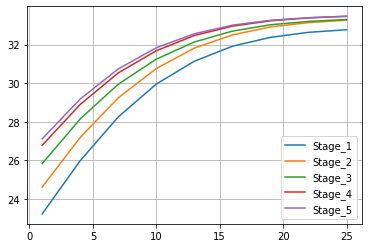

.......... 90 epochs - 27.44s/epoch - val_loss: 0.005659916903823614 - val_Decoder_1_PSNR: 31.38800048828125 - val_Decoder_2_PSNR: 32.059532165527344 - val_Decoder_3_PSNR: 32.467472076416016 - val_Decoder_4_PSNR: 32.73725509643555 - val_Decoder_5_PSNR: 32.94035720825195
.........INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


. 100 epochs - 27.30s/epoch - val_loss: 0.005487512331455946 - val_Decoder_1_PSNR: 31.493606567382812 - val_Decoder_2_PSNR: 32.19976043701172 - val_Decoder_3_PSNR: 32.56382751464844 - val_Decoder_4_PSNR: 32.86449432373047 - val_Decoder_5_PSNR: 33.034358978271484


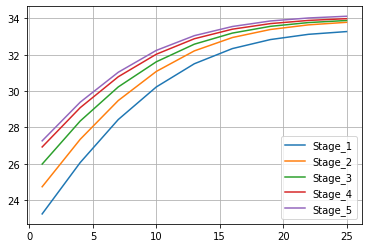

.......... 110 epochs - 26.76s/epoch - val_loss: 0.0054310341365635395 - val_Decoder_1_PSNR: 31.422101974487305 - val_Decoder_2_PSNR: 32.22256088256836 - val_Decoder_3_PSNR: 32.577720642089844 - val_Decoder_4_PSNR: 32.930965423583984 - val_Decoder_5_PSNR: 32.9388542175293
.......... 120 epochs - 26.11s/epoch - val_loss: 0.005208208691328764 - val_Decoder_1_PSNR: 31.69330596923828 - val_Decoder_2_PSNR: 32.428890228271484 - val_Decoder_3_PSNR: 32.81199645996094 - val_Decoder_4_PSNR: 33.138431549072266 - val_Decoder_5_PSNR: 33.3218994140625


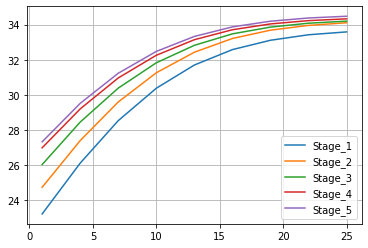

.......... 130 epochs - 26.72s/epoch - val_loss: 0.0051304250955581665 - val_Decoder_1_PSNR: 31.667295455932617 - val_Decoder_2_PSNR: 32.490966796875 - val_Decoder_3_PSNR: 32.869300842285156 - val_Decoder_4_PSNR: 33.140098571777344 - val_Decoder_5_PSNR: 33.35276794433594
.......... 140 epochs - 25.97s/epoch - val_loss: 0.005007835570722818 - val_Decoder_1_PSNR: 31.67391586303711 - val_Decoder_2_PSNR: 32.529327392578125 - val_Decoder_3_PSNR: 32.92366409301758 - val_Decoder_4_PSNR: 33.30299758911133 - val_Decoder_5_PSNR: 33.53230285644531


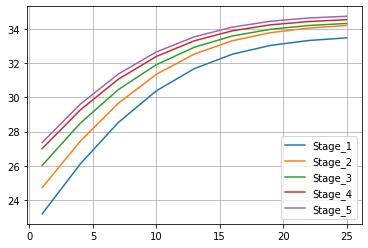

.........INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


. 150 epochs - 27.76s/epoch - val_loss: 0.004989194218069315 - val_Decoder_1_PSNR: 31.62209129333496 - val_Decoder_2_PSNR: 32.30379867553711 - val_Decoder_3_PSNR: 32.75209426879883 - val_Decoder_4_PSNR: 33.05250549316406 - val_Decoder_5_PSNR: 33.236324310302734
.......... 160 epochs - 26.46s/epoch - val_loss: 0.004807216115295887 - val_Decoder_1_PSNR: 31.796968460083008 - val_Decoder_2_PSNR: 32.594635009765625 - val_Decoder_3_PSNR: 33.05517578125 - val_Decoder_4_PSNR: 33.3057746887207 - val_Decoder_5_PSNR: 33.42344665527344


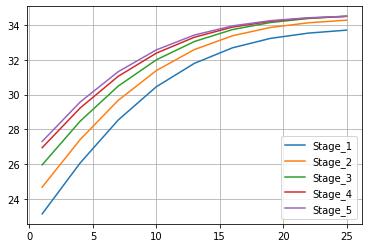

.......... 170 epochs - 26.97s/epoch - val_loss: 0.004630640149116516 - val_Decoder_1_PSNR: 31.846067428588867 - val_Decoder_2_PSNR: 32.7868766784668 - val_Decoder_3_PSNR: 33.22443771362305 - val_Decoder_4_PSNR: 33.64785385131836 - val_Decoder_5_PSNR: 33.80481719970703
.......... 180 epochs - 26.10s/epoch - val_loss: 0.004551155958324671 - val_Decoder_1_PSNR: 31.83686065673828 - val_Decoder_2_PSNR: 32.80625915527344 - val_Decoder_3_PSNR: 33.21043395996094 - val_Decoder_4_PSNR: 33.559417724609375 - val_Decoder_5_PSNR: 33.78311538696289


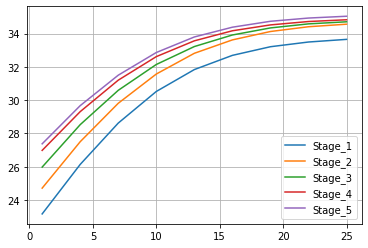

.......... 190 epochs - 26.72s/epoch - val_loss: 0.004427745472639799 - val_Decoder_1_PSNR: 31.932891845703125 - val_Decoder_2_PSNR: 32.9454460144043 - val_Decoder_3_PSNR: 33.41608428955078 - val_Decoder_4_PSNR: 33.80393600463867 - val_Decoder_5_PSNR: 33.844425201416016
.........INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


. 200 epochs - 27.01s/epoch - val_loss: 0.004439947661012411 - val_Decoder_1_PSNR: 31.779895782470703 - val_Decoder_2_PSNR: 32.794837951660156 - val_Decoder_3_PSNR: 33.262325286865234 - val_Decoder_4_PSNR: 33.57986831665039 - val_Decoder_5_PSNR: 33.72951889038086


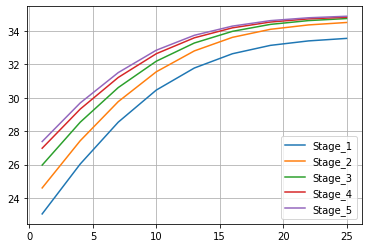

.......... 210 epochs - 26.72s/epoch - val_loss: 0.004320124629884958 - val_Decoder_1_PSNR: 31.89300537109375 - val_Decoder_2_PSNR: 32.992034912109375 - val_Decoder_3_PSNR: 33.49415969848633 - val_Decoder_4_PSNR: 33.76449966430664 - val_Decoder_5_PSNR: 33.94535827636719
.......... 220 epochs - 25.97s/epoch - val_loss: 0.004280319903045893 - val_Decoder_1_PSNR: 31.976659774780273 - val_Decoder_2_PSNR: 33.03190994262695 - val_Decoder_3_PSNR: 33.379920959472656 - val_Decoder_4_PSNR: 33.82773971557617 - val_Decoder_5_PSNR: 34.033668518066406


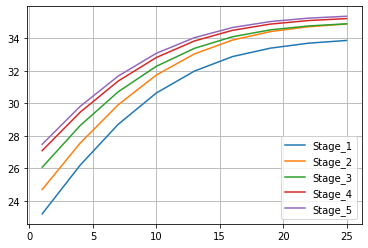

.......... 230 epochs - 26.84s/epoch - val_loss: 0.004194024484604597 - val_Decoder_1_PSNR: 32.045352935791016 - val_Decoder_2_PSNR: 33.19586944580078 - val_Decoder_3_PSNR: 33.606727600097656 - val_Decoder_4_PSNR: 33.98323059082031 - val_Decoder_5_PSNR: 34.25402069091797
.......... 240 epochs - 26.08s/epoch - val_loss: 0.004177376162260771 - val_Decoder_1_PSNR: 32.041175842285156 - val_Decoder_2_PSNR: 33.25400161743164 - val_Decoder_3_PSNR: 33.67424774169922 - val_Decoder_4_PSNR: 34.09437561035156 - val_Decoder_5_PSNR: 34.29700469970703


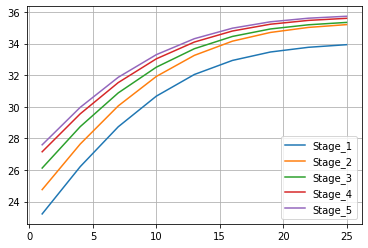

.........INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


. 250 epochs - 27.72s/epoch - val_loss: 0.00414658896625042 - val_Decoder_1_PSNR: 32.150550842285156 - val_Decoder_2_PSNR: 33.29902267456055 - val_Decoder_3_PSNR: 33.71220397949219 - val_Decoder_4_PSNR: 34.10665512084961 - val_Decoder_5_PSNR: 34.257869720458984
.......... 260 epochs - 26.01s/epoch - val_loss: 0.004153526853770018 - val_Decoder_1_PSNR: 32.01765823364258 - val_Decoder_2_PSNR: 33.243160247802734 - val_Decoder_3_PSNR: 33.67427444458008 - val_Decoder_4_PSNR: 34.08457565307617 - val_Decoder_5_PSNR: 34.33992004394531


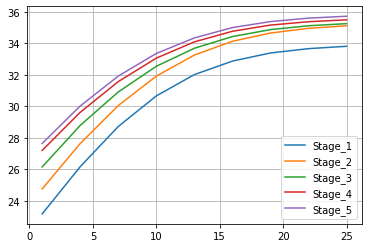

.......... 270 epochs - 26.68s/epoch - val_loss: 0.0041112094186246395 - val_Decoder_1_PSNR: 32.140953063964844 - val_Decoder_2_PSNR: 33.318443298339844 - val_Decoder_3_PSNR: 33.75244140625 - val_Decoder_4_PSNR: 34.07180404663086 - val_Decoder_5_PSNR: 34.327823638916016
.......... 280 epochs - 25.86s/epoch - val_loss: 0.004201676696538925 - val_Decoder_1_PSNR: 31.956697463989258 - val_Decoder_2_PSNR: 33.102108001708984 - val_Decoder_3_PSNR: 33.272579193115234 - val_Decoder_4_PSNR: 33.77798080444336 - val_Decoder_5_PSNR: 33.929527282714844


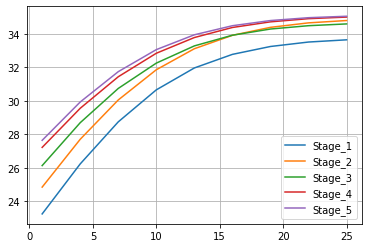

.......... 290 epochs - 26.66s/epoch - val_loss: 0.004101448226720095 - val_Decoder_1_PSNR: 31.981189727783203 - val_Decoder_2_PSNR: 33.125022888183594 - val_Decoder_3_PSNR: 33.74270248413086 - val_Decoder_4_PSNR: 34.11677551269531 - val_Decoder_5_PSNR: 34.308448791503906
.........INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


. 300 epochs - 27.02s/epoch - val_loss: 0.004119014833122492 - val_Decoder_1_PSNR: 31.994234085083008 - val_Decoder_2_PSNR: 32.97904586791992 - val_Decoder_3_PSNR: 33.462982177734375 - val_Decoder_4_PSNR: 33.99858474731445 - val_Decoder_5_PSNR: 33.91804504394531


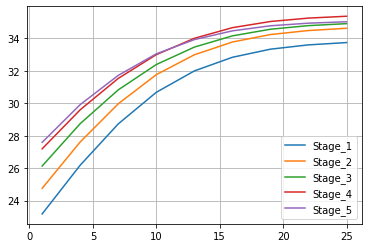

.......... 310 epochs - 26.51s/epoch - val_loss: 0.003991970792412758 - val_Decoder_1_PSNR: 32.1613883972168 - val_Decoder_2_PSNR: 33.379581451416016 - val_Decoder_3_PSNR: 33.804866790771484 - val_Decoder_4_PSNR: 34.22991180419922 - val_Decoder_5_PSNR: 34.416297912597656
.......... 320 epochs - 25.93s/epoch - val_loss: 0.003936804365366697 - val_Decoder_1_PSNR: 32.26660919189453 - val_Decoder_2_PSNR: 33.48232650756836 - val_Decoder_3_PSNR: 33.904781341552734 - val_Decoder_4_PSNR: 34.335960388183594 - val_Decoder_5_PSNR: 34.49079132080078


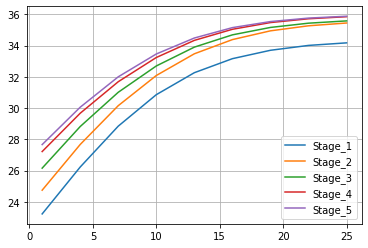

.......... 330 epochs - 26.83s/epoch - val_loss: 0.003919699229300022 - val_Decoder_1_PSNR: 32.14387130737305 - val_Decoder_2_PSNR: 33.4962158203125 - val_Decoder_3_PSNR: 33.9659309387207 - val_Decoder_4_PSNR: 34.4721565246582 - val_Decoder_5_PSNR: 34.57201385498047
.......... 340 epochs - 25.87s/epoch - val_loss: 0.0039512082003057 - val_Decoder_1_PSNR: 32.21235275268555 - val_Decoder_2_PSNR: 33.381595611572266 - val_Decoder_3_PSNR: 33.565399169921875 - val_Decoder_4_PSNR: 34.062232971191406 - val_Decoder_5_PSNR: 34.43678283691406


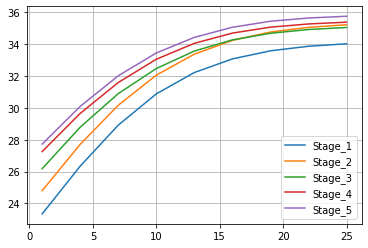

.........INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


. 350 epochs - 27.58s/epoch - val_loss: 0.0038293295074254274 - val_Decoder_1_PSNR: 32.121971130371094 - val_Decoder_2_PSNR: 33.5672607421875 - val_Decoder_3_PSNR: 33.995662689208984 - val_Decoder_4_PSNR: 34.51808547973633 - val_Decoder_5_PSNR: 34.67252731323242
.......... 360 epochs - 25.93s/epoch - val_loss: 0.003980008419603109 - val_Decoder_1_PSNR: 31.811420440673828 - val_Decoder_2_PSNR: 33.083492279052734 - val_Decoder_3_PSNR: 33.61455154418945 - val_Decoder_4_PSNR: 34.038902282714844 - val_Decoder_5_PSNR: 34.365020751953125


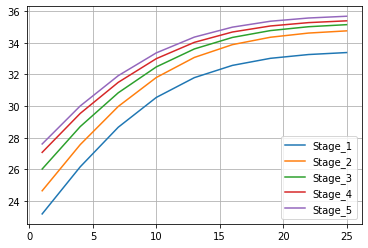

.......... 370 epochs - 26.63s/epoch - val_loss: 0.0038272137753665447 - val_Decoder_1_PSNR: 32.16917037963867 - val_Decoder_2_PSNR: 33.530357360839844 - val_Decoder_3_PSNR: 34.020751953125 - val_Decoder_4_PSNR: 34.41752243041992 - val_Decoder_5_PSNR: 34.59607696533203
.......... 380 epochs - 26.13s/epoch - val_loss: 0.003848820924758911 - val_Decoder_1_PSNR: 32.109004974365234 - val_Decoder_2_PSNR: 33.40839385986328 - val_Decoder_3_PSNR: 33.950340270996094 - val_Decoder_4_PSNR: 34.36030960083008 - val_Decoder_5_PSNR: 34.498817443847656


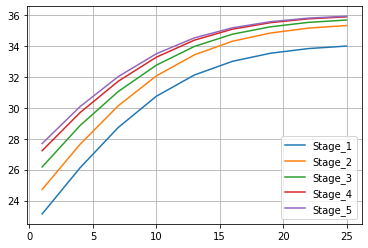

.......... 390 epochs - 26.76s/epoch - val_loss: 0.0037950784899294376 - val_Decoder_1_PSNR: 32.239105224609375 - val_Decoder_2_PSNR: 33.51506805419922 - val_Decoder_3_PSNR: 34.13641357421875 - val_Decoder_4_PSNR: 34.50319290161133 - val_Decoder_5_PSNR: 34.72444534301758
.........INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


. 400 epochs - 26.97s/epoch - val_loss: 0.003758050734177232 - val_Decoder_1_PSNR: 32.315086364746094 - val_Decoder_2_PSNR: 33.71143341064453 - val_Decoder_3_PSNR: 34.15644073486328 - val_Decoder_4_PSNR: 34.57819747924805 - val_Decoder_5_PSNR: 34.77359390258789


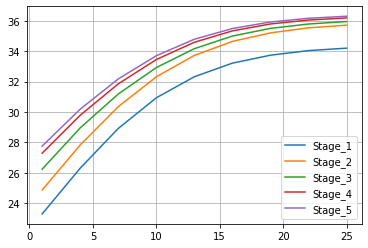

.......... 410 epochs - 26.70s/epoch - val_loss: 0.0037501242477446795 - val_Decoder_1_PSNR: 32.34973907470703 - val_Decoder_2_PSNR: 33.694950103759766 - val_Decoder_3_PSNR: 34.17329406738281 - val_Decoder_4_PSNR: 34.55795669555664 - val_Decoder_5_PSNR: 34.790225982666016
.......... 420 epochs - 25.98s/epoch - val_loss: 0.003761864034458995 - val_Decoder_1_PSNR: 32.28885269165039 - val_Decoder_2_PSNR: 33.650787353515625 - val_Decoder_3_PSNR: 34.1202278137207 - val_Decoder_4_PSNR: 34.5318717956543 - val_Decoder_5_PSNR: 34.73802185058594


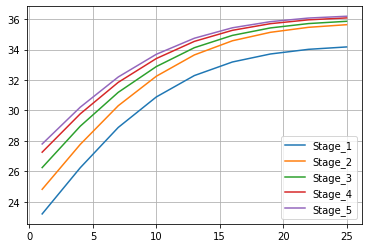

.......... 430 epochs - 26.62s/epoch - val_loss: 0.003754615318030119 - val_Decoder_1_PSNR: 32.298519134521484 - val_Decoder_2_PSNR: 33.63277053833008 - val_Decoder_3_PSNR: 34.17292785644531 - val_Decoder_4_PSNR: 34.53387451171875 - val_Decoder_5_PSNR: 34.73973083496094
.......... 440 epochs - 25.89s/epoch - val_loss: 0.0036994782276451588 - val_Decoder_1_PSNR: 32.395206451416016 - val_Decoder_2_PSNR: 33.81193542480469 - val_Decoder_3_PSNR: 34.352718353271484 - val_Decoder_4_PSNR: 34.75505065917969 - val_Decoder_5_PSNR: 34.84880828857422


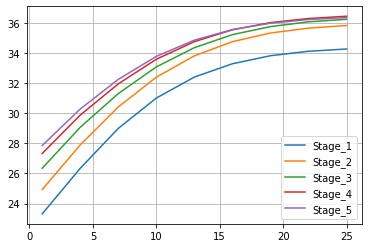

.........INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


. 450 epochs - 27.62s/epoch - val_loss: 0.003722788766026497 - val_Decoder_1_PSNR: 32.32318115234375 - val_Decoder_2_PSNR: 33.76567459106445 - val_Decoder_3_PSNR: 34.24028015136719 - val_Decoder_4_PSNR: 34.606388092041016 - val_Decoder_5_PSNR: 34.847835540771484
.......... 460 epochs - 26.04s/epoch - val_loss: 0.0036694735754281282 - val_Decoder_1_PSNR: 32.38309860229492 - val_Decoder_2_PSNR: 33.82487869262695 - val_Decoder_3_PSNR: 34.323265075683594 - val_Decoder_4_PSNR: 34.742103576660156 - val_Decoder_5_PSNR: 34.99911117553711


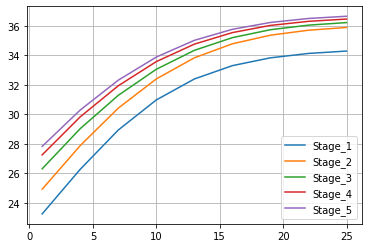

.......... 470 epochs - 26.75s/epoch - val_loss: 0.00370894861407578 - val_Decoder_1_PSNR: 32.20155715942383 - val_Decoder_2_PSNR: 33.555076599121094 - val_Decoder_3_PSNR: 33.985103607177734 - val_Decoder_4_PSNR: 34.52060317993164 - val_Decoder_5_PSNR: 34.81242370605469
.......... 480 epochs - 25.96s/epoch - val_loss: 0.003682146081700921 - val_Decoder_1_PSNR: 32.30988693237305 - val_Decoder_2_PSNR: 33.568077087402344 - val_Decoder_3_PSNR: 34.058502197265625 - val_Decoder_4_PSNR: 34.5401496887207 - val_Decoder_5_PSNR: 34.79983139038086


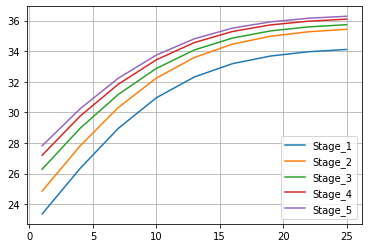

.......... 490 epochs - 26.85s/epoch - val_loss: 0.003679973306134343 - val_Decoder_1_PSNR: 32.20579528808594 - val_Decoder_2_PSNR: 33.54286193847656 - val_Decoder_3_PSNR: 34.022865295410156 - val_Decoder_4_PSNR: 34.34235763549805 - val_Decoder_5_PSNR: 34.77190399169922
.......

In [ ]:
model.fit(trainX, trainX, batch_size = batch_size, initial_epoch = 0, epochs = epochs, validation_data = (testX, testX),
          callbacks = [ed_cb, lr_cb, plt_cb, cp_weights_cb, cp_model_cb], verbose = 0)

In [ ]:
#model.save_weights(cp_weights_filepath)
model.save(cp_model_filepath)

model.load_weights(cp_weights_filepath)

raw_model.save(os.path.join(JSCC_dir, 'raw_model'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/raw_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Stuff/Efficient_successive_img_tr/JSCC_2/raw_model/assets


In [ ]:
model.evaluate(testX, testX)

79/79 [==============================] - 34s 14ms/step - loss: 0.0032 - Decoder_1_PSNR: 33.0263 - Decoder_2_PSNR: 34.4052 - Decoder_3_PSNR: 35.0518 - Decoder_4_PSNR: 35.4468 - Decoder_5_PSNR: 35.6162


[0.003553110873326659,
 32.308860778808594,
 33.759708404541016,
 34.40188217163086,
 34.79707717895508,
 34.99766540527344]

# Test

## Different SNRs

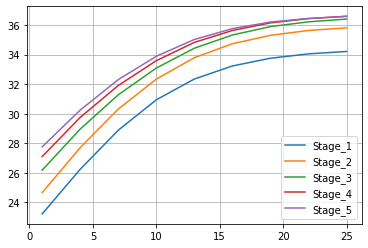

In [ ]:
PSNR_plotter(test_SNRs, model, channel, testX, stages_count, goal)

## Stage results

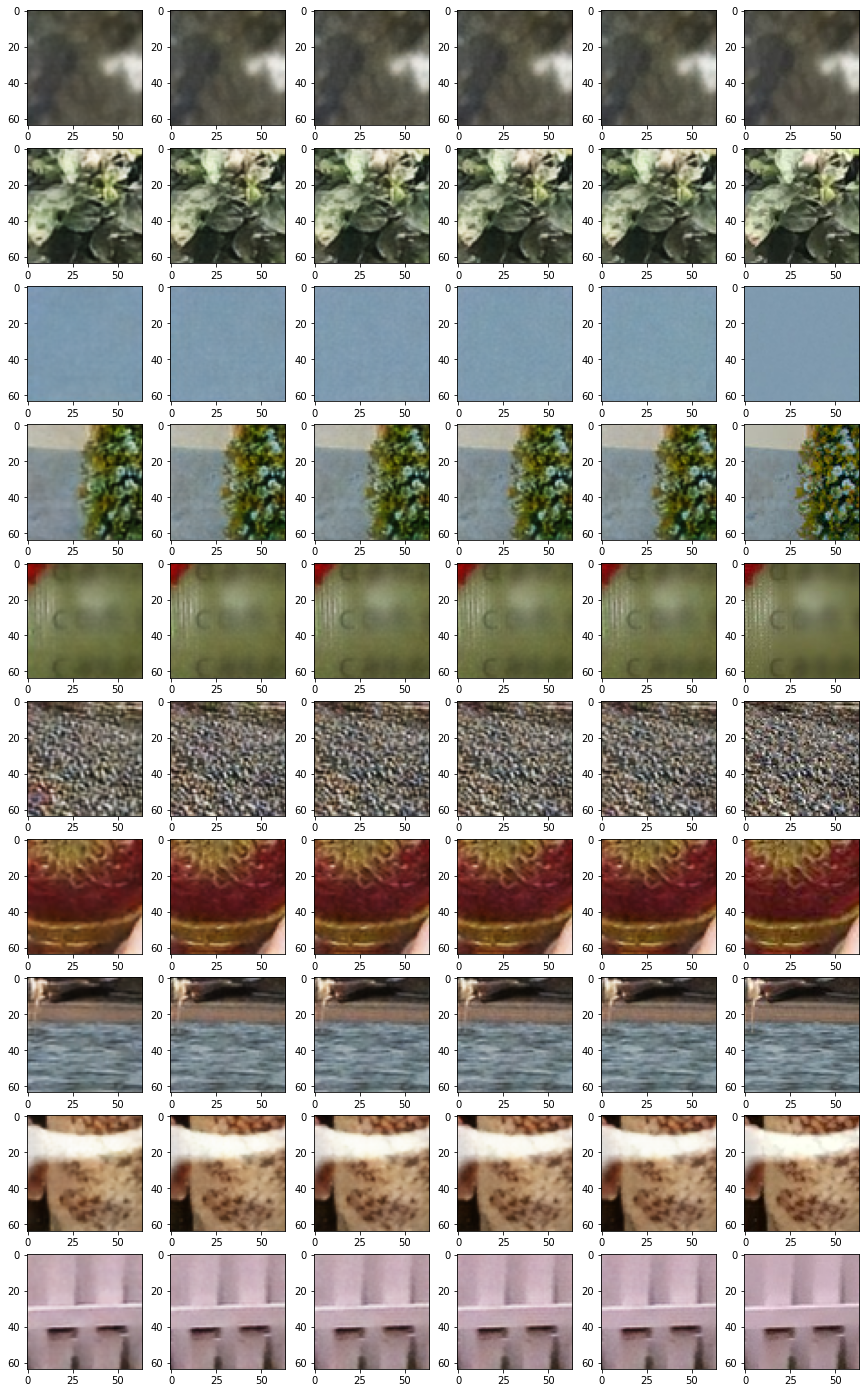

In [ ]:
idxs = np.random.randint(0, len(testX), 10)
imgs = testX[idxs]
preds = []
losses = []

preds = model(imgs)

fig = plt.figure(figsize = (2.5 * (stages_count + 1), 2.5 * len(imgs)))
for i in range(len(imgs)):
  for j in range(stages_count):
    pred = preds[j][i].numpy()
    fig.add_subplot(len(imgs), stages_count + 1, i*(stages_count + 1) + j + 1)
    plt.imshow(pred)

  fig.add_subplot(len(imgs), stages_count + 1, (i + 1)*(stages_count + 1))
  plt.imshow(imgs[i])
plt.show()